<table style="float:left; border:none">
   <tr style="border:none">
       <td style="border:none">  
           <img 
               src="" 
               style="width:10px"
           >
           </a>    
       </td>
   </tr>
</table>
<div style="float:right;"><h2>13. Whole population light gbm classifier OPTUNA</h2></div>

 <a id="top"></a> <br>
## Índice
1. [Entradas y Entregable](#1)<br>
    1.1. [Entradas del modelo](#11)<br>
    1.2. [Entregable](#12)<br>
2. [Carga de paquetes y datos](#2)<br>
    2.1. [Librerías y clases](#21)<br>
    2.2. [Lectura de datos](#22)<br>
    2.3. [Eliminación de valores nulos](#23)<br>
    2.4. [Binarización de variable delta_WHP](#24)<br>
    2.5. [Separación en train y test](#25)<br>
3. [Modelo](#3)<br>
    3.1. [Confección pipeline](#31)<br>
    3.2. [Optimización de hiperparámetros](#32)<br>
    3.3. [Entrenamiento del modelo](#33)<br>
    3.4. [Mejores Hiperparámetros](#34)<br>
4. [Evaluación del modelo](#4)<br>
    4.1. [Cálculo de métricas](#41)<br>
    4.2. [Matriz de confusión](#42)<br>
    4.3. [ROC Curve](#43)<br>
    4.4. [Precision-Recall curve](#44)<br>

***
<a id="1"></a> <br>
## 1. Entradas y Entregable

<a id="11"></a>
### 1.1. Entradas

|Tipo|Nombre|Descripción|Ubicación Lab|
|:-------|----------------|---------------------------------------------------|-------------------------------------|
|**csv**| `Dataset participantes.csv` | datos relacionados con los pozos al producirse una interferencia por la estimulación de un pozo hijo |`/content/drive/MyDrive/DataScience/TRABAJOS PARTICULARES/YPF/DATASET/`|

<a id="12"></a>
### 1.2. Entregable

**Archivo csv con las estimaciones de delta_WHP**

***
<a id="2"></a> <br>
## 2. Carga de paquetes y datos

<a id="21"></a>
### 2.1. Librerías y clases

In [31]:
! pip install optuna
! pip install feature_engine

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [32]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px

import statsmodels.api as sm

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score, KFold
from sklearn.metrics import recall_score, confusion_matrix, roc_curve, average_precision_score, precision_recall_curve, plot_precision_recall_curve, make_scorer, fbeta_score, mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, binarize
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
import lightgbm as lgb
import optuna
from feature_engine.selection import DropFeatures

import chardet

import warnings
warnings.filterwarnings("ignore")

In [33]:
# Esta función grafica los residuos de las predicciones del modelo
def diag_residuos (y, prediccion):

    # Diagnóstico errores (residuos) de las predicciones de entrenamiento
    # ==============================================================================
    residuos   = prediccion - y
    # Gráficos
    # ==============================================================================
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18, 15))

    axes[0, 0].scatter(y, prediccion, edgecolors=(0, 0, 0), alpha = 0.4)
    axes[0, 0].plot([y.min(), y.max()], [y.min(), y.max()],'k--', color = 'black', lw=2)
    axes[0, 0].set_title('Valor predicho vs valor real', fontsize = 10, fontweight = "bold")
    axes[0, 0].set_xlabel('Real')
    axes[0, 0].set_ylabel('Predicción')
    axes[0, 0].tick_params(labelsize = 7)

    axes[0, 1].scatter(list(range(len(y))), residuos, edgecolors=(0, 0, 0), alpha = 0.4)
    axes[0, 1].axhline(y = 0, linestyle = '--', color = 'black', lw=2)
    axes[0, 1].set_title('Residuos del modelo', fontsize = 10, fontweight = "bold")
    axes[0, 1].set_xlabel('id')
    axes[0, 1].set_ylabel('Residuo')
    axes[0, 1].tick_params(labelsize = 7)

    sns.histplot( data = residuos, stat = "density", kde = True, line_kws= {'linewidth': 1}, color = "firebrick", alpha   = 0.3, ax = axes[1, 0])

    axes[1, 0].set_title('Distribución residuos del modelo', fontsize = 10, fontweight = "bold")
    axes[1, 0].set_xlabel("Residuo")
    axes[1, 0].tick_params(labelsize = 7)


    sm.qqplot( residuos, fit = True, line  = 'q', ax = axes[1, 1], color = 'firebrick', alpha = 0.4, lw = 2 )

    axes[1, 1].set_title('Q-Q residuos del modelo', fontsize = 10, fontweight = "bold")
    axes[1, 1].tick_params(labelsize = 7)

    axes[2, 0].scatter(prediccion, residuos, edgecolors=(0, 0, 0), alpha = 0.4)
    axes[2, 0].axhline(y = 0, linestyle = '--', color = 'black', lw=2)
    axes[2, 0].set_title('Residuos del modelo vs predicción', fontsize = 10, fontweight = "bold")
    axes[2, 0].set_xlabel('Predicción')
    axes[2, 0].set_ylabel('Residuo')
    axes[2, 0].tick_params(labelsize = 7)

    # Se eliminan los axes vacíos
    fig.delaxes(axes[2,1])

    fig.tight_layout()
    plt.subplots_adjust(top=0.9)
    fig.suptitle('Diagnóstico residuos', fontsize = 12, fontweight = "bold");

<a id="22"></a> <br>
### 2.2. Lectura de datos

In [34]:
# Detección automática de la codificación de los caracteres
with open("/content/drive/MyDrive/DataScience/TRABAJOS PARTICULARES/YPF/DATASET/Dataset participantes (corregido).csv", 'rb') as f:
    enc = chardet.detect(f.read())  # or readline if the file is large

# Lectura del csv
df = pd.read_csv("/content/drive/MyDrive/DataScience/TRABAJOS PARTICULARES/YPF/DATASET/Dataset participantes (corregido).csv",encoding = enc['encoding'], index_col=0)

df.sample(5)

,ID_EVENTO,CAMPO,FLUIDO,PAD_HIJO,HIJO,ETAPA_HIJO,PADRE,D3D,D2D,DZ,AZ,#_BARRERAS,LINEAMIENTO,WHP_i,delta_WHP,ESTADO
ID_FILA,,,,,,,,,,,,,,,,
16912,Pozo 479-Pozo 129-8,Campo C,GAS,PAD-21,Pozo 479,8,Pozo 129,1502.719321,1502.591603,-19.591626,191.299430,2.0,NO,430.2,0.0,Abierto
8852,Pozo 367-Pozo 44-2,Campo F,OIL,PAD-82,Pozo 367,2,Pozo 44,1276.983388,1276.849693,18.477982,57.624697,1.0,NO,59.9,0.0,Abierto
4121,Pozo 240-Pozo 74-13,Campo F,OIL,PAD-73,Pozo 240,13,Pozo 74,1130.262989,1130.194452,-12.446884,25.544717,0.0,NO,38.8,0.0,Abierto
940,Pozo 407-Pozo 231-23,Campo F,OIL,PAD-60,Pozo 407,23,Pozo 231,1243.197959,1241.864533,57.564303,268.967751,0.0,NO,13.8,0.0,Abierto
15052,Pozo 122-Pozo 126-21,Campo C,GAS,PAD-19,Pozo 122,21,Pozo 126,625.945129,624.183238,46.931752,264.586999,1.0,NO,314.3,0.0,Abierto


In [35]:
# Se cambia el tipo de datos de variables categóricas nominales de object a category
df = df.astype({"CAMPO": "category", "FLUIDO": "category", "PAD_HIJO": "category", "HIJO": "category",
                "ETAPA_HIJO": "category", "PADRE": "category", "LINEAMIENTO": "category", "ESTADO": "category"})
df.dtypes

ID_EVENTO        object
CAMPO          category
FLUIDO         category
PAD_HIJO       category
HIJO           category
ETAPA_HIJO     category
PADRE          category
D3D             float64
D2D             float64
DZ              float64
AZ              float64
#_BARRERAS      float64
LINEAMIENTO    category
WHP_i           float64
delta_WHP       float64
ESTADO         category
dtype: object

<a id="23"></a> <br>
### 2.3. Eliminación de valores nulos
**Dado que el modelo a desarrollar en el presente notebook será tomado como baseline, se eliminan los valores nulos para mayor practicidad**

In [36]:
print("Cantidad de instancias totales =", df.shape[0])
# Eliminación de todos los valores nulos de dataset
df.dropna(inplace=True)
print("Cantidad de instancias sin valores nulos =", df.shape[0])

Cantidad de instancias totales = 26178
Cantidad de instancias sin valores nulos = 26178


<a id="24"></a> <br>
### 2.4. Binarización de variable delta_WHP

In [37]:
# Se crea una nueva variable en donde se asigna valor 0 cuando delta_WHP = 0 y valor 1 cuando delta_WHP != 0
df["delta_WHP_binarized"] = df["delta_WHP"].apply(lambda val: 1 if val != 0 else 0)

<a id="25"></a> <br>
### 2.5. Separación en train y test

In [38]:
# Selección de variable target
y = df.delta_WHP
# Selección de features
X = df.drop('delta_WHP', axis=1)

# Separación en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25,  stratify= X.delta_WHP_binarized, random_state = 161)

# Verificación de distribución de variable targuet en train y test
print("Instancias de train \n", X_train.shape[0])
print("Instancias de test \n", X_test.shape[0])

Instancias de train 
 19633
Instancias de test 
 6545


In [39]:
# Función objetivo de optuna
kfold = KFold(n_splits=3, random_state=48, shuffle=True)
def objective_pipe(trial):
  scores = []
  # ===============================================================================================================
  # ESPACIO DE HIPERPARÁMETROS

  # Hiperparámetros modelo clasificador
  params_class = {
          'random_state': 48,
          'max_depth': trial.suggest_int("max_depth_class", 2, 300),
          'learning_rate':  trial.suggest_float("learning_rate_class", 0.001, 1),
          'n_estimators': trial.suggest_int("n_estimators_class", 5, 5000),
          #'min_data_in_leaf' : trial.suggest_int("min_data_in_leaf_class",2, 500),
          #'bagging_fraction':trial.suggest_categorical('bagging_fraction_class',[0.1, 0.2, 0.4, 0.5, 0.6, 0.7,0.8]),
          #'reg_alpha': trial.suggest_categorical('reg_alpha_class',[0, 1e-1, 1, 2, 5, 7, 10, 50, 100]),
          #'reg_lambda': trial.suggest_categorical('reg_lambda_class',[0, 1e-1, 1, 5, 10, 20, 50, 100])
                        }
  # Selección de umbral modelo de clasificación
  c_threshold = trial.suggest_float("c_threshold", 0.001, 0.99)  # Hiperparámetro umbral
  # Hiperparámetros modelo regresor
  params_reg = { 
            'random_state': 48,
           'n_estimators': trial.suggest_int("n_estimators_reg", 5, 5000),
          #'reg_alpha':   trial.suggest_categorical('reg_alpha_reg',[0, 1e-1, 1, 2, 20, 50, 100, 250, 500]),
         #'colsample_bytree': trial.suggest_categorical('colsample_bytree_reg', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
         #'subsample': trial.suggest_categorical('subsample_reg', [0.4,0.5,0.6,0.7,0.8,1.0]),
          'learning_rate': trial.suggest_float("learning_rate_reg", 0.001, 1),
          'max_depth': trial.suggest_int("max_depth_reg", 2, 300),
          'num_leaves' : trial.suggest_int('num_leaves_reg', 2, 1000),
          #'min_child_samples': trial.suggest_int('min_child_samples_reg', 2, 300),
          #'cat_smooth' : trial.suggest_int('min_data_per_groups_reg', 2, 150)

        }
  
  # Pipeline modelo clasificador
  light_gbm_class = lgb.LGBMClassifier(**params_class)
    
  pipe_class = Pipeline([ ("DropFeatures", DropFeatures(["ID_EVENTO"])),
                      
                      ("column_transformer",ColumnTransformer([
                                            ("standard_scaler", StandardScaler(), 
                        ["D3D", "D2D", "DZ", "AZ", "WHP_i", "#_BARRERAS"])])),
                                    
                                    ("light_gbm_class", light_gbm_class)])
  
  # Pipeline modelo regresor
  light_gbm_reg = lgb.LGBMRegressor(**params_reg)
    
  pipe_reg = Pipeline([ ("DropFeatures", DropFeatures(["ID_EVENTO"])),
                      
                      ("column_transformer",ColumnTransformer([
                                            ("standard_scaler", StandardScaler(), 
                        ["D3D", "D2D", "DZ", "AZ", "WHP_i", "#_BARRERAS"])])),
                                    
                                    ("light_gbm_reg", light_gbm_reg)])
  
  # enumerate splits
  for train_index, test_index in kfold.split(X_train):

    # =======================================================================================================================================================================================
    # DATA ENTRENAMIENTO CLASIFICADOR Y REGRESOR

    # Obtengo data entrenamiento y testeo Kfold para modelo clasificador
    X_train_class, X_test_class = X_train[X_train.index.isin(train_index)].drop('delta_WHP_binarized', axis=1), X_train[X_train.index.isin(test_index)].drop('delta_WHP_binarized', axis=1)
    y_train_class, y_test_class = X_train[X_train.index.isin(train_index)].delta_WHP_binarized, X_train[X_train.index.isin(test_index)].delta_WHP_binarized

    # Obtengo data entrenamiento y testeo Kfold para modelo regresor
    X_train_reg, X_test_reg = X_train[X_train.index.isin(train_index)].drop('delta_WHP_binarized', axis=1), X_train[X_train.index.isin(test_index)].drop('delta_WHP_binarized', axis=1)
    y_train_reg, y_test_reg = y_train[y_train.index.isin(train_index)], y_train[y_train.index.isin(test_index)]

    # =======================================================================================================================================================================================
    # CLASIFICADOR

    # Entrenamiento clasificador
    c_model = pipe_class.fit(X_train_class, y_train_class)

    # ===============================================================================================================================
    # SELECCIÓN DE UNIVERSO DE ENTRENAMIENTO DE REGRESOR A PARTIR DEL UMBRAL DEL MODELO DE CLASIFICACIÓN

    # Scores clasificador
    c_scores = c_model.predict_proba(X_train_class)

    # Predicciones clasificador en función del valor de c_threshold
    c_pred = binarize(c_scores, threshold = c_threshold)[:,1]

    # Selección de universo de entrenamiento
    df_c_pred = pd.DataFrame(c_pred).set_index(y_train_class.index) # seteo indice del y_train_class a las predicciones del clasificador
    df_ones_pred = df_c_pred[df_c_pred.iloc[:, 0]==1]    # Me quedo con las predicciones iguales a uno del clasificador


      # Subset entrenamiento modelo regresor
    X_train_reg_ones = X_train_reg[X_train_reg.index.isin(df_ones_pred.index)] # Features de entrenamiento del regresor con las instancias predichas como uno del clasificador
    y_train_reg_ones = y_train_reg[y_train_reg.index.isin(df_ones_pred.index)] # Target de entrenamiento del regresor con las instancias predichas como uno del clasificador
    
    if X_train_reg_ones.shape[0] > 1: # Esto me asegura que el clasificador haya predicho algun 1, sino no puedo entrenar el regresor   
      # ===============================================================================================================================
      # ENTRENAMIENTO REGRESOR
      model_reg = pipe_reg.fit(X_train_reg_ones, y_train_reg_ones)
      # ==========================================================================================================================================================
      # SCOREO DEL MODELO 
      
      # Scores clasificador
      c_scores_test = c_model.predict_proba(X_test_class)
      # Predicciones clasificador en función del valor de c_threshold
      c_pred_test = binarize(c_scores_test, threshold = c_threshold)[:,1]

      # Selección de universo de testeo
      df_c_pred_test = pd.DataFrame(c_pred_test).set_index(y_test_class.index) # seteo indice del y_test_class a las predicciones del clasificador
      df_ones_pred_test = df_c_pred_test[df_c_pred_test.iloc[:, 0]==1]    # Me quedo con las predicciones iguales a uno del clasificador

      # Subset testeo modelo regresor
      X_test_reg_ones = X_test_reg[X_test_reg.index.isin(df_ones_pred_test.index)] # Features de testeo del regresor con las instancias predichas como uno del clasificador
      y_test_reg_ones = y_test_reg[y_test_reg.index.isin(df_ones_pred_test.index)] # Target de testeo del regresor con las instancias predichas como uno del clasificador

      # Subset testeo modelo regresor reglas duras
      X_test_zeros = X_test_reg[~X_test_reg.index.isin(df_ones_pred_test.index)] # Features reglas duras con las instancias predichas como cero del clasificador
      y_test_zeros = y_test_reg[~y_test_reg.index.isin(df_ones_pred_test.index)] # Target reglas duras con las instancias predichas como cero del clasificador
      
      
      
      
      ################### REGLAS DURAS ###########################################
      
      





################# ESTO USAR PARA CONCATENAR pd.merge(df1, df2, on='ID_FILA') 
      
      
      # Predicciones set de testeo
      y_test_pred = model_reg.predict(X_test_reg_ones)
      y_test_pred = pd.DataFrame(y_test_pred).set_index(y_test_reg_ones.index)

      # Primera evaluación la hacemos sin escorear los ceros para ver la diferencia entre lo predicho y el valor cero ###################################
      y_pred = pd.concat([y_test_pred, y_test_zeros], axis = 0, ignore_index = False)
      df_eval = pd.concat([y_pred, y_test_reg], axis = 1, ignore_index = False)

      # evaluate model
      RMSE = mean_squared_error(df_eval.iloc[:, 0], df_eval.iloc[:, 1], squared = False)
    else:
      RMSE = math.sqrt(np.square(y_test_reg).mean()) # Al haber predecido todos cero el clasificador, el RMSE lo calculo con el vector target solo 
    # store score
    scores.append(RMSE)
    # summarize model performance
  RMSE = np.mean(scores)

  return RMSE

In [40]:
%%time
models=[]
scores=[]
pipe_study = optuna.create_study(direction='minimize')
pipe_study.optimize(objective_pipe, n_trials=50)
model='light_gbm'
score=pipe_study.best_trial.value
models.append(model)
scores.append(score)

[I 2022-11-11 20:36:07,269] A new study created in memory with name: no-name-d069723c-ab65-4265-8b9f-0a73465af187
[I 2022-11-11 20:36:12,576] Trial 0 finished with value: 0.4826437380415965 and parameters: {'max_depth_class': 112, 'learning_rate_class': 0.6349132322541674, 'n_estimators_class': 1095, 'c_threshold': 0.657084105452281, 'n_estimators_reg': 2528, 'learning_rate_reg': 0.533387277779642, 'max_depth_reg': 199, 'num_leaves_reg': 815}. Best is trial 0 with value: 0.4826437380415965.
[I 2022-11-11 20:36:52,806] Trial 1 finished with value: 3.6202964510663187 and parameters: {'max_depth_class': 81, 'learning_rate_class': 0.2528580925137357, 'n_estimators_class': 4880, 'c_threshold': 0.3401733352887386, 'n_estimators_reg': 812, 'learning_rate_reg': 0.7651170716854915, 'max_depth_reg': 86, 'num_leaves_reg': 631}. Best is trial 0 with value: 0.4826437380415965.
[I 2022-11-11 20:36:55,514] Trial 2 finished with value: 3.0044268683699236 and parameters: {'max_depth_class': 84, 'learni

CPU times: user 11min 26s, sys: 21.7 s, total: 11min 48s
Wall time: 6min 27s


In [41]:
print('Number of finished trials:', len(pipe_study.trials))
print('Best trial: score {}, params {}'.format(pipe_study.best_trial.value, pipe_study.best_trial.params))

Number of finished trials: 50
Best trial: score 0.40292292354331033, params {'max_depth_class': 57, 'learning_rate_class': 0.8444389696817776, 'n_estimators_class': 2374, 'c_threshold': 0.4659149296271968, 'n_estimators_reg': 52, 'learning_rate_reg': 0.48045255085611505, 'max_depth_reg': 263, 'num_leaves_reg': 548}


In [42]:
optuna.visualization.plot_optimization_history(pipe_study)

In [43]:
optuna.visualization.plot_parallel_coordinate(pipe_study)

In [44]:
optuna.visualization.plot_slice(pipe_study)

In [45]:
optuna.visualization.plot_param_importances(pipe_study)

In [46]:
optuna.visualization.plot_edf(pipe_study)

In [47]:
optuna.visualization.plot_contour(pipe_study)

<a id="37"></a> <br>
### 3.7. Entrenamiento del modelo con mejores hiperparámetros

In [48]:
pipe_study.best_trial.params

{'max_depth_class': 57,
 'learning_rate_class': 0.8444389696817776,
 'n_estimators_class': 2374,
 'c_threshold': 0.4659149296271968,
 'n_estimators_reg': 52,
 'learning_rate_reg': 0.48045255085611505,
 'max_depth_reg': 263,
 'num_leaves_reg': 548}

In [50]:
## Dict con mejores hiperparámetros para modelo clasificador
best_params_class = {
        'light_gbm_class__random_state': 48,
        'light_gbm_class__max_depth': pipe_study.best_trial.params["max_depth_class"],
        'light_gbm_class__learning_rate': pipe_study.best_trial.params["learning_rate_class"],
        'light_gbm_class__n_estimators': pipe_study.best_trial.params["n_estimators_class"],
        #'light_gbm_class__min_data_in_leaf' : pipe_study.best_trial.params["min_data_in_leaf_class"],
        #'light_gbm_class__bagging_fraction':pipe_study.best_trial.params['bagging_fraction_class'],
        #'light_gbm_class__reg_alpha': pipe_study.best_trial.params['reg_alpha_class'],
        #'light_gbm_class__reg_lambda': pipe_study.best_trial.params['reg_lambda_class']
                      }
# Dict con mejores hiperparámetros para modelo regresor
best_params_reg = {
        'light_gbm_reg__random_state': 48,
        'light_gbm_reg__n_estimators': pipe_study.best_trial.params["n_estimators_reg"],
        #'light_gbm_reg__reg_alpha': pipe_study.best_trial.params['reg_alpha_reg'],
        'light_gbm_reg__learning_rate':pipe_study.best_trial.params["learning_rate_reg"],
        'light_gbm_reg__max_depth': pipe_study.best_trial.params["max_depth_reg"],
        'light_gbm_reg__num_leaves' : pipe_study.best_trial.params['num_leaves_reg'],
        #'light_gbm_reg__min_child_samples' : pipe_study.best_trial.params['min_child_samples_reg']
        #'light_gbm_reg__min_data_per_groups' : pipe_study.best_trial.params['min_data_per_groups_reg'],
        #'light_gbm_class__min_data_in_leaf' : pipe_study.best_trial.params["min_data_in_leaf_lgbm"],
        #'light_gbm_class__bagging_fraction':pipe_study.best_trial.params['bagging_fraction_class'],
        #'light_gbm_class__reg_lambda': pipe_study.best_trial.params['reg_lambda_lgbm']
                      }
# Mejor Threshold modelo clasificador                      
c_threshold = pipe_study.best_trial.params['c_threshold']



In [51]:
# Obtengo data entrenamiento y testeo para modelo clasificador
X_train_class ,X_test_class = X_train.drop('delta_WHP_binarized', axis=1), X_test.drop('delta_WHP_binarized', axis=1)
y_train_class, y_test_class = X_train.delta_WHP_binarized, X_test.delta_WHP_binarized

# Obtengo data entrenamiento y testeo para modelo regresor
X_train_reg, X_test_reg = X_train.drop('delta_WHP_binarized', axis=1), X_test.drop('delta_WHP_binarized', axis=1)
y_train_reg, y_test_reg = y_train, y_test

In [52]:
# Pipeline modelo clasificador
light_gbm_class = lgb.LGBMClassifier()
    
pipe_class = Pipeline([ ("DropFeatures", DropFeatures(["ID_EVENTO"])),
                      
                      ("column_transformer",ColumnTransformer([
                                            ("standard_scaler", StandardScaler(), 
                        ["D3D", "D2D", "DZ", "AZ", "WHP_i", "#_BARRERAS"])])),
                                    
                                    ("light_gbm_class", light_gbm_class)])

In [53]:
# Pipeine modelo regresor
light_gbm_reg = lgb.LGBMRegressor()
    
pipe_reg = Pipeline([ ("DropFeatures", DropFeatures(["ID_EVENTO"])),
                      
                      ("column_transformer",ColumnTransformer([
                                            ("standard_scaler", StandardScaler(), 
                        ["D3D", "D2D", "DZ", "AZ", "WHP_i", "#_BARRERAS"])])),
                                    
                                    ("light_gbm_reg", light_gbm_reg)])

In [54]:
# Seteado de mejores hiperparámetros modelo clasificador
pipe_class.set_params(**best_params_class)

# Entrenamiento modelo clasificador
c_model = pipe_class.fit(X_train_class, y_train_class)

In [55]:
# Scores clasificador
c_scores_train = c_model.predict_proba(X_train_class)

# Predicciones clasificador en función del valor de c_threshold
c_pred = binarize(c_scores_train, threshold = c_threshold)[:,1]

# Selección de universo de entrenamiento
df_c_pred = pd.DataFrame(c_pred).set_index(y_train_class.index) # seteo indice del y_train_class a las predicciones del clasificador
df_ones_pred = df_c_pred[df_c_pred.iloc[:, 0]==1]    # Me quedo con las predicciones iguales a uno del clasificador

if df_ones_pred.shape[0] > 0: # Esto me asegura que el clasificador haya predicho algun 1, sino no puedo entrenar el regresor
  # Subset entrenamiento modelo regresor
  X_train_reg_ones = X_train_reg[X_train_reg.index.isin(df_ones_pred.index)] # Features de entrenamiento del regresor con las instancias predichas como uno del clasificador
  y_train_reg_ones = y_train_reg[y_train_reg.index.isin(df_ones_pred.index)] # Target de entrenamiento del regresor con las instancias predichas como uno del clasificador

  # Subset train modelo regresor reglas duras
  X_train_zeros = X_train_reg[~X_train_reg.index.isin(df_ones_pred.index)] # Features reglas duras con las instancias predichas como cero del clasificador
  y_train_zeros = y_train_reg[~y_train_reg.index.isin(df_ones_pred.index)] # Target reglas duras con las instancias predichas como cero del clasificador
  # ===============================================================================================================================
    
  # ENTRENAMIENTO REGRESOR
  pipe_reg.set_params(**best_params_reg)
  model_reg = pipe_reg.fit(X_train_reg_ones, y_train_reg_ones)

  #============================================================================================================================================


  y_train_pred = model_reg.predict(X_train_reg_ones)
  y_train_pred = pd.DataFrame(y_train_pred).set_index(y_train_reg_ones.index)

  # Primera evaluación la hacemos sin escorear los ceros para ver la diferencia entre lo predicho y el valor cero ###################################
  y_pred = pd.concat([y_train_pred, y_train_zeros], axis = 0, ignore_index = False)
  df_eval = pd.concat([y_pred, y_train_reg], axis = 1, ignore_index = False) # Dataframe con todas las predicciones y valores reales

  # evaluate model
  RMSE_train = mean_squared_error(df_eval.iloc[:, 0], df_eval.iloc[:, 1], squared = False)

else:
  RMSE_train = math.sqrt(np.square(y_train_reg).mean()) # Al haber predecido todos cero el clasificador, el RMSE lo calculo con el vector target solo

In [56]:
# Scores clasificador
c_scores_test = c_model.predict_proba(X_test_class)

# Predicciones clasificador en función del valor de c_threshold
c_pred_test = binarize(c_scores_test, threshold = c_threshold)[:,1]

# Selección de universo de entrenamiento
df_c_pred_test = pd.DataFrame(c_pred_test).set_index(y_test_class.index) # seteo indice del y_train_class a las predicciones del clasificador
df_ones_pred_test = df_c_pred_test[df_c_pred_test.iloc[:, 0]==1]    # Me quedo con las predicciones iguales a uno del clasificador

if df_ones_pred_test.shape[0] > 0: # Esto me asegura que el clasificador haya predicho algun 1, sino no puedo entrenar el regresor
  # Subset entrenamiento modelo regresor
  X_test_reg_ones = X_test_reg[X_test_reg.index.isin(df_ones_pred_test.index)] # Features de entrenamiento del regresor con las instancias predichas como uno del clasificador
  y_test_reg_ones = y_test_reg[y_test_reg.index.isin(df_ones_pred_test.index)] # Target de entrenamiento del regresor con las instancias predichas como uno del clasificador

  # Subset train modelo regresor reglas duras
  X_test_zeros = X_test_reg[~X_test_reg.index.isin(df_ones_pred_test.index)] # Features reglas duras con las instancias predichas como cero del clasificador
  y_test_zeros = y_test_reg[~y_test_reg.index.isin(df_ones_pred_test.index)] # Target reglas duras con las instancias predichas como cero del clasificador
  # ===============================================================================================================================

  y_test_pred = model_reg.predict(X_test_reg_ones)
  y_test_pred = pd.DataFrame(y_test_pred).set_index(y_test_reg_ones.index)

  # Primera evaluación la hacemos sin escorear los ceros para ver la diferencia entre lo predicho y el valor cero ###################################
  y_pred_test = pd.concat([y_test_pred, y_test_zeros], axis = 0, ignore_index = False)
  df_eval_test = pd.concat([y_pred_test, y_test_reg], axis = 1, ignore_index = False) # Dataset con todas las predicciones y valores reales

  # evaluate model
  RMSE_test = mean_squared_error(df_eval_test.iloc[:, 0], df_eval_test.iloc[:, 1], squared = False)

else:
  RMSE_test = math.sqrt(np.square(y_test_reg).mean()) # Al haber predecido todos cero el clasificador, el RMSE lo calculo con el vector target solo

In [57]:
print('RMSE model train: ', RMSE_train)
print('RMSE model test: ', RMSE_test)

RMSE model train:  0.03672729737792405
RMSE model test:  0.14508776923776825


In [72]:
df_c_pred_test

,0
ID_FILA,
1301,0.0
13578,0.0
11288,0.0
24642,0.0
11835,0.0
...,...
18144,0.0
12076,0.0
2497,0.0


***
<a id="#4"></a> <br>
## 4. Evaluación del modelo

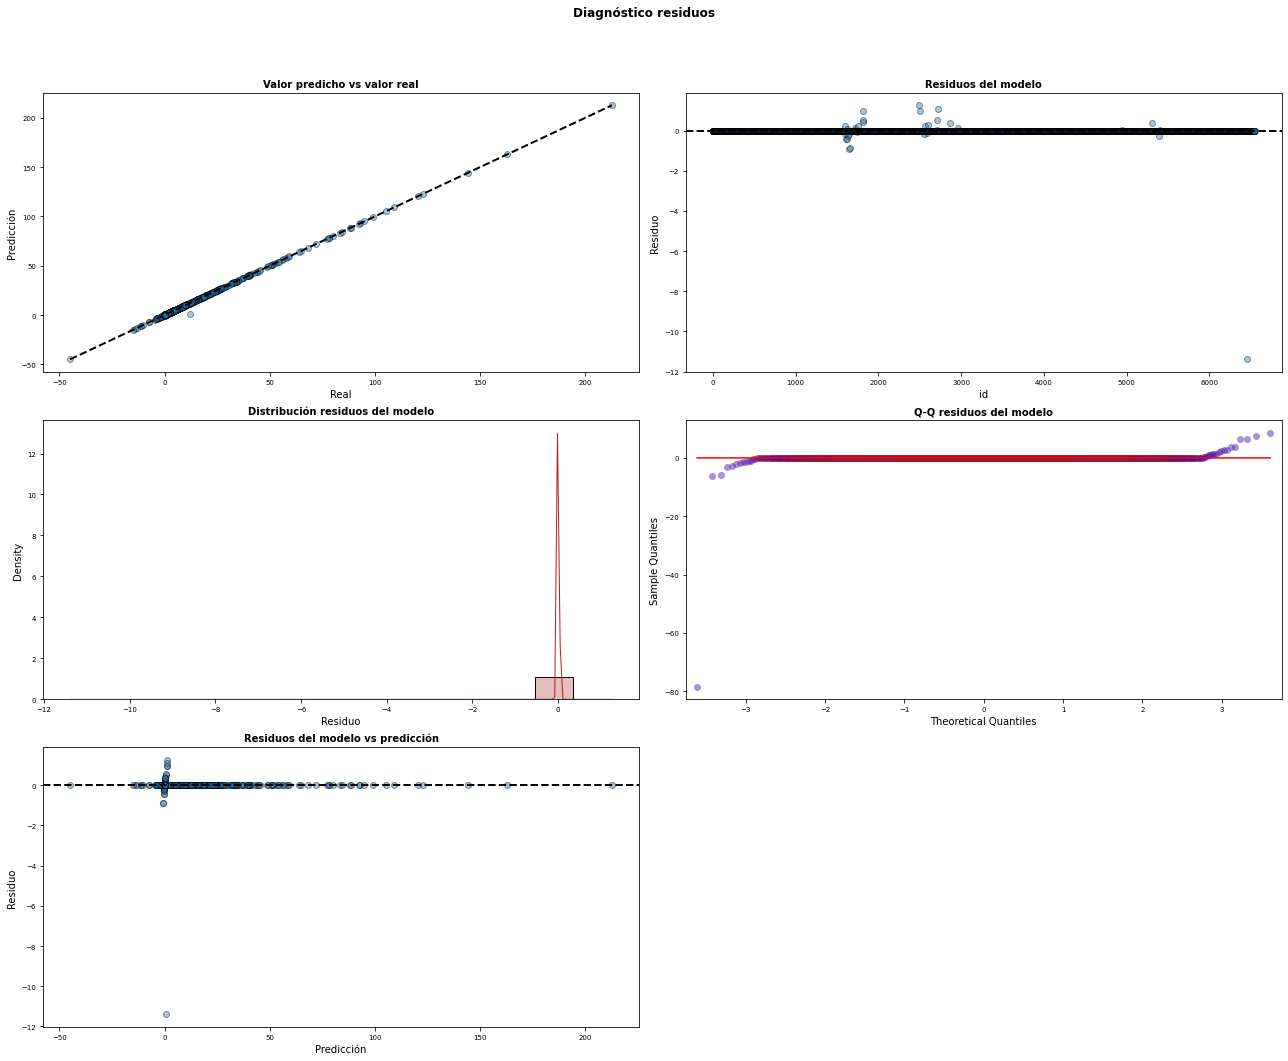

In [58]:
diag_residuos(df_eval_test.iloc[:, 1],df_eval_test.iloc[:, 0])

In [61]:
import pickle

with open('/content/drive/MyDrive/DataScience/TRABAJOS PARTICULARES/YPF/NOTEBOOKS/MODELOS APARTE/r_model_no_rules.pickle', 'wb') as f:
    pickle.dump(model_reg, f)

In [62]:
with open('/content/drive/MyDrive/DataScience/TRABAJOS PARTICULARES/YPF/NOTEBOOKS/MODELOS APARTE/c_model_no_rules.pickle', 'wb') as f:
    pickle.dump(c_model, f)

<a id="41"></a> <br>
### 4.1. Cálculo de métricas

In [ ]:
# recall_score
ftwo_score_train = fbeta_score(y_train, model.predict(X_train), beta = 2)
print("F2 train = ", ftwo_score_train)
ftwo_score_test = fbeta_score(y_test, model.predict(X_test), beta = 2)
print("F2 test = ", ftwo_score_test)

<a id="42"></a> <br>
### 4.2. Matriz de confusión

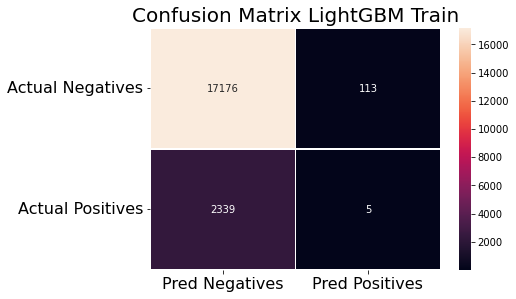

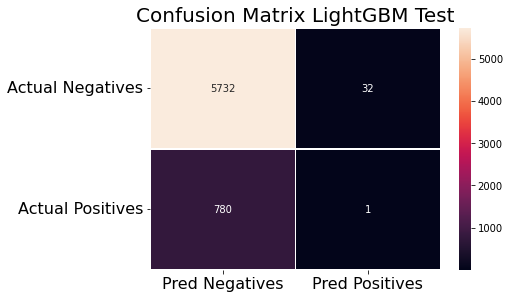

In [74]:
# Matriz de confusión para modelo
conf_matrix = confusion_matrix(y_train_class,  c_model.predict(X_train_class))
f, ax = plt.subplots(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", linewidths=.6, ax=ax)
plt.title("Confusion Matrix LightGBM Train", fontsize=20)
plt.subplots_adjust(left=0.15, right=0.99, bottom=0.15, top=0.99)
ax.set_yticks(np.arange(conf_matrix.shape[0]) + 0.5, minor=False)
ax.set_xticklabels(['Pred Negatives', 'Pred Positives'],fontsize=16, rotation=360)
ax.set_yticklabels(['Actual Negatives', 'Actual Positives'], fontsize=16, rotation=360)
plt.show()

conf_matrix = confusion_matrix(y_test_class,  c_model.predict(X_test_class))
f, ax = plt.subplots(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", linewidths=.6, ax=ax)
plt.title("Confusion Matrix LightGBM Test", fontsize=20)
plt.subplots_adjust(left=0.15, right=0.99, bottom=0.15, top=0.99)
ax.set_yticks(np.arange(conf_matrix.shape[0]) + 0.5, minor=False)
ax.set_xticklabels(['Pred Negatives', 'Pred Positives'],fontsize=16, rotation=360)
ax.set_yticklabels(['Actual Negatives', 'Actual Positives'], fontsize=16, rotation=360)
plt.show()

<a id="43"></a> <br>
### 4.3. ROC Curve

In [ ]:
# Obtencion de predicciones para graficar curva ROC
probsdmodel = model.predict_proba(X_test)
predsdmodel = probsdmodel[:,1]

lr_false_positive_rate,lr_true_positive_rate,lr_threshold = roc_curve(y_test,predsdmodel)


# Grafico curva ROC
sns.set_style('whitegrid')
plt.figure(figsize=(10,5))
plt.title('Reciver Operating Characterstic Curve')
plt.plot(lr_false_positive_rate,lr_true_positive_rate,label='LightGBM Classifier')

plt.plot([0,1],ls='--')
plt.plot([0,0],[1,0],c='.5')
plt.plot([1,1],c='.5')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.legend()
plt.show()

<a id="44"></a> <br>
### 4.4. Precision-Recall Curve

In [ ]:
# Curva Precision-Recall
average_precision = average_precision_score(y_test, predsdmodel)

print(average_precision)

disp = plot_precision_recall_curve(model, X_test, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'Average Precision={0:0.2f}'.format(average_precision));

In [ ]:


y_true = y_test
y_pred =  model.predict_proba(X_test)[:,1]

scored_df = pd.DataFrame()
scored_df['target'] = y_test
scored_df['1'] = y_pred
scored_df.index = y_true.index
scored_df.sample(2)

# Define paths de y_true, y_pred_proba
#path_y_true = "tmp/test_set.gz"
y_true_col = "target"

#path_y_pred = "tmp/y_pred_proba_lgbm.csv"
y_pred_col = "1"

#id_col = "cus_cust_id_borrower"

# Define función para unificar target y predicción
def get_scored_df(path_y_true, path_y_pred):
    labels = pd.read_csv(path_y_true, usecols=[id_col, y_true_col])
    preds = pd.read_csv(path_y_pred)
    scored = pd.merge(left=labels, right=preds, left_index=True, right_index=True)
    scored[y_pred_col] = scored[y_pred_col].apply(lambda x: round(x*100, 2))
    return scored

# Armado de dataframe scoreado
#scored_df = get_scored_df(path_y_true, path_y_pred)
scored_df.sort_values(y_pred_col, ascending=False, inplace=True, ignore_index=True)
scored_df

# Reemplaza separador decimal
to_hr = lambda x: "{:,}".format(x).replace(",", ".")

# Preprocesamiento del df scoreado + métricas
pps = [round(x, 3) for x in np.arange(0.001, 1.001, 0.001)]
precisions = list()
recalls = list()
kss = list()
msgs_prec = list()
msgs_recall = list()
msgs_ks = list()
total_clientes = scored_df.shape[0]
total_0s = scored_df[y_true_col].value_counts()[0]
total_1s = scored_df[y_true_col].value_counts()[1]
for pp in pps:
    slice_idx = int(total_clientes * pp)
    current_df = scored_df.loc[:slice_idx-1, :]
    try:
      current_0s = current_df[y_true_col].value_counts()[0]
    except:
      current_0s = 0
    try:
      current_1s = current_df[y_true_col].value_counts()[1]
    except:
      current_1s = 0
    precisions.append(current_1s / slice_idx)
    msgs_prec.append("({} de {})".format(to_hr(current_1s), to_hr(slice_idx)))
    gain_1 = current_1s / total_1s
    recalls.append(gain_1)
    msgs_recall.append("({} de {})".format(to_hr(current_1s), to_hr(total_1s)))
    kss.append(gain_1 - (current_0s / total_0s))

# Genera df con métricas
metrics_df = pd.DataFrame({
    "PP": pps,
    "PRECISION": precisions,
    "RECALL": recalls,
    "KS": kss,
    "msg_PRECISION": msgs_prec,
    "msg_RECALL": msgs_recall})

metrics_df

# Calcula métricas
dfs = list()
for c, new_name in [("PRECISION", "PRECISION"),
                    ("RECALL", "RECALL"),
                    ("KS", "KS")]:
    cdf = metrics_df[["PP", c]].copy()
    cdf.rename(columns={c: "VALOR"}, inplace=True)
    cdf["METRICA"] = new_name
    cdf["msg"] = metrics_df["msg_" + c] if c != "KS" else ""
    dfs.append(cdf)
    
# Unifica df scoreado + métricas para plotear
plot_df = pd.concat(dfs)
for c in ["PP", "VALOR"]:
    plot_df[c] = plot_df[c].apply(lambda x: x*100)

# Plotea
fig = px.line(
    plot_df, x="PP", y="VALOR", color="METRICA",
    width=1000, height=700, text=plot_df["msg"],
    hover_data=["METRICA"])

fig.update_layout(
    hovermode="x",
    font_size=15,
    legend_title_text=None,
    paper_bgcolor="rgba(0, 0, 0, 0)",
    title=dict(text="Modelo Conversión TC MLB - Métricas", font_size=25),
    xaxis=dict(range=[0, 100], title=dict(text="Población (ordenada de mayor a menor score)"), dtick=10),
    yaxis=dict(range=[0, 100], title=dict(text="Valor de la métrica"), dtick=10),
    font=dict(color="black"),
    hoverlabel=dict(font_size=16,))

fig.update_traces(mode="lines", hovertemplate="%{y:.1f}% %{text}")
fig.update_xaxes(showspikes=True, spikecolor="gray", spikesnap="cursor", spikemode="across", ticksuffix="%")
fig.update_yaxes(ticksuffix="%")
fig.update_layout(spikedistance=1000, hoverdistance=100)
fig.show()

<a id="42"></a> <br>
### 4.2. Análisis de False Negative

In [77]:
model_predict_proba_train = c_model.predict_proba(X_train_class)
model_pred_train = binarize(model_predict_proba_train, threshold = 0.45)[:,1]

model_predict_proba_test = c_model.predict_proba(X_test_class)
model_pred_test = binarize(model_predict_proba_test, threshold = 0.45)[:,1]

In [79]:
# recall_score
ftwo_score_train = fbeta_score(y_train_class, model_pred_train, beta = 2)
print("F2 train = ", ftwo_score_train)
ftwo_score_test = fbeta_score(y_test_class, model_pred_test, beta = 2)
print("F2 test = ", ftwo_score_test)

F2 train =  0.002633242047609016
F2 test =  0.0015837820715869494


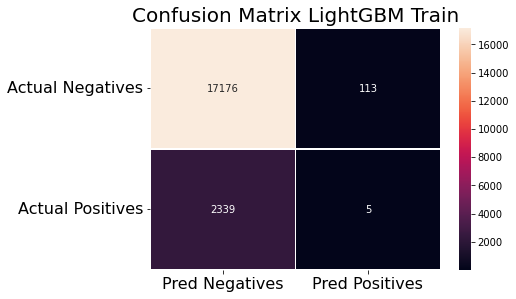

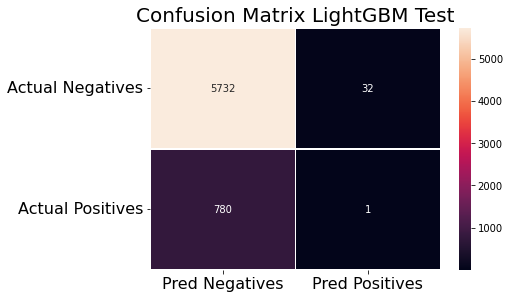

In [81]:
# Matriz de confusión para modelo
conf_matrix = confusion_matrix(y_train_class, model_pred_train)
f, ax = plt.subplots(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", linewidths=.6, ax=ax)
plt.title("Confusion Matrix LightGBM Train", fontsize=20)
plt.subplots_adjust(left=0.15, right=0.99, bottom=0.15, top=0.99)
ax.set_yticks(np.arange(conf_matrix.shape[0]) + 0.5, minor=False)
ax.set_xticklabels(['Pred Negatives', 'Pred Positives'],fontsize=16, rotation=360)
ax.set_yticklabels(['Actual Negatives', 'Actual Positives'], fontsize=16, rotation=360)
plt.show()

conf_matrix = confusion_matrix(y_test_class, model_pred_test)
f, ax = plt.subplots(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", linewidths=.6, ax=ax)
plt.title("Confusion Matrix LightGBM Test", fontsize=20)
plt.subplots_adjust(left=0.15, right=0.99, bottom=0.15, top=0.99)
ax.set_yticks(np.arange(conf_matrix.shape[0]) + 0.5, minor=False)
ax.set_xticklabels(['Pred Negatives', 'Pred Positives'],fontsize=16, rotation=360)
ax.set_yticklabels(['Actual Negatives', 'Actual Positives'], fontsize=16, rotation=360)
plt.show()